# **QUESTION 3**

In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
cudnn.benchmark = True
plt.ion()   # interactive mode

We are importing the required libraries here.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = '/content/drive/MyDrive/hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Here we are loading the dataset as recommended in the tutorial

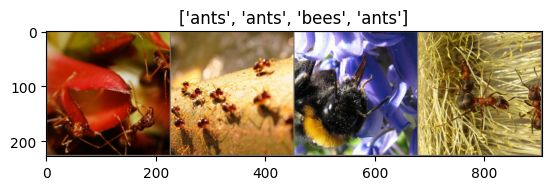

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

We are visualizing a few images above

In [ ]:
# This is a general function to train a model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        # Each epoch has a training and validation phase !..something i realized the hard way by computing on CPU instead of GPU
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode..
            else:
                model.eval()   # Set model to evaluate mode..
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

We are training the model above as per the instructions in the tutorial

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

We are visualizing the model predictions above..as recommended in the tutorial

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


We are finetuning the ConvNet above as recommended in the question...it was not compulsory i guess but still went ahead with it :p

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5522 Acc: 0.6721
val Loss: 0.3523 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.8116 Acc: 0.7254
val Loss: 0.4388 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.6650 Acc: 0.7377
val Loss: 0.5226 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.4717 Acc: 0.8484
val Loss: 0.3763 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.4513 Acc: 0.8033
val Loss: 0.3256 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.4669 Acc: 0.7992
val Loss: 0.3562 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.4818 Acc: 0.8197
val Loss: 0.2341 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3712 Acc: 0.8607
val Loss: 0.2245 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.4509 Acc: 0.7951
val Loss: 0.2335 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2978 Acc: 0.8770
val Loss: 0.2286 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3248 Acc: 0.8607
val Loss: 0.2306 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2817 Acc: 0.8811
val Loss: 0.2064 Acc: 0.9281

Ep

We are training and evaluating the model above...please use GPU instead of CPU here!

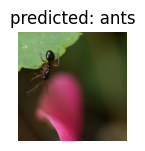

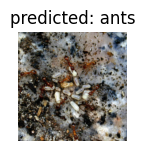

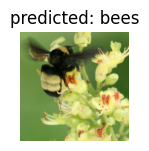

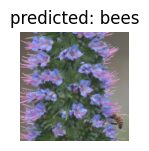

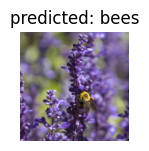

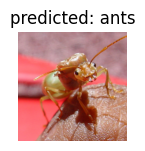

In [ ]:
visualize_model(model_ft)

We are visualizing the predictions above

# **We conclude Question 3a) above**

In [ ]:
from PIL import Image
from torch.autograd import Variable

# Reference Used : https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c

# ResNet-18 expects images to be at least 224x224, as well as normalized with a specific mean and standard deviation.
# Hence, we will first define some PyTorch transforms:

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

# Use the model object to select the desired layer
layer = model_ft._modules.get('avgpool')

In [ ]:
# Additional reference used to get around a bug in the code : https://stackoverflow.com/questions/61606416/runtimeerror-output-with-shape-512-doesnt-match-the-broadcast-shape-1-512

def get_vector(inputs):
    # Create a PyTorch Variable with the transformed image...the basic step here
    t_img = Variable(inputs.unsqueeze(0))
    # Create a vector of zeros that will hold our feature vector
    my_embedding = torch.zeros(512) # The 'avgpool' layer has an output size of 512..what is required by us for the q
    # Define an inner function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.reshape(o.data.size(1)))
    # Attach that function to the selected layer
    h = layer.register_forward_hook(copy_data)
    # Run the model on the transformed image
    model_ft(t_img)
    # Detach the copy function from the layer
    h.remove()
    # Return the feature vector
    return my_embedding

I was unable to understand this part of the question and a senior helped me with this part only..attaching his github link here:https://github.com/codeWITHswap/EE769_IML this really helped me get a grasp over this question

In [ ]:
features = np.zeros((512,1))
labels = np.zeros((1,1))
for img in image_datasets['train']: # img[0] is a PyTorch tensor whereas img[1] refers to the class : ants/bees
    img_tensor = img[0].to(device)
    img_feature = get_vector(img_tensor)
    img_feature = img_feature.numpy()
    img_feature = img_feature.reshape(len(img_feature),1)
    features = np.concatenate((features, img_feature), axis = 1)
    img_label = img[1]
    img_label = np.array(img_label)
    img_label = img_label.reshape(1,1)
    labels = np.concatenate((labels, img_label), axis = 1)
features = features.T
labels = labels.T

Again got great help from the Github repo which allowed us specifically to navigate this question

In [ ]:
x = features[1:,:]# ready with our ingredients now :p
y = labels[1:,:]

We are successful in writing a  function that outputs ResNet18 features for a given input image, extracting features for training images (in image_datasets['train']). We get an Nx512 dimensional array.

# **We successfully conclude question 3b) above**

In [ ]:
from sklearn import svm

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import load_iris

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state = 101 )#the usual step :p

In [ ]:
# Define Random Forest classifier
rf_classifier = RandomForestClassifier()
# Define parameter grid for grid search
param_grid = {
    'n_estimators': [ 10 , 20 , 30 , 40 , 50, 60 , 70 , 80 , 90, 100] , # Number of trees in the forest..as told to us
    'max_depth': [ None, 10 , 15 ,  20 , 25 , 30]  # Maximum depth of the tree..as told in the question
}
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train.ravel())
# Get the best parameters and best score
best_params = grid_search.best_params_
print("Best Parameters:", best_params)



Best Parameters: {'max_depth': 20, 'n_estimators': 70}
Best Score: 0.9794871794871796


In [ ]:
# Train a Random Forest classifier with the best parameters
best_rf_classifier = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                             max_depth=best_params['max_depth'])
best_rf_classifier.fit(X_train, y_train.ravel())
# Evaluate the classifier on the test set
print("\nClassification Report:")
test_accuracy = best_rf_classifier.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Classification Report:
Test Accuracy: 0.9795918367346939


In [ ]:
y_pred = best_rf_classifier.predict(X_test)
print(classification_report( y_test, y_pred ) )
print("Test Accuracy:", test_accuracy)

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        27
         1.0       1.00      0.95      0.98        22

    accuracy                           0.98        49
   macro avg       0.98      0.98      0.98        49
weighted avg       0.98      0.98      0.98        49

Test Accuracy: 0.9795918367346939


So we get our test accuracy and also print our F1 score for **Random Forest Classifier**

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
# Split dataset into train and test sets...
X_train, X_test, y_train, y_test = train_test_split(x , y, test_size=0.2, random_state=42)
# Define parameter grid for grid search
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10]}
# Create SVM classifier with RBF kernel
svm = SVC(kernel='rbf');
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5);
grid_search.fit(X_train, y_train.ravel())
# Print best parameters found by grid search
print("Best parameters found by grid search:")
print(grid_search.best_params_)

Best parameters found by grid search:
{'C': 1, 'gamma': 0.001}


In [ ]:
# Evaluate model on test set using best parameters
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)
# Print classification report
print("\nClassification Report:")
print(classification_report( y_test, y_pred ) )
print("Test Accuracy:", test_accuracy)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        27
         1.0       1.00      0.95      0.98        22

    accuracy                           0.98        49
   macro avg       0.98      0.98      0.98        49
weighted avg       0.98      0.98      0.98        49

Test Accuracy: 0.9591836734693877


So we get our test accuracy and also print our F1 score for ** RBF kernel using SVC**
ChatGPT helped me rectify some unexpected syntax errors

# **With this we conclude Question 3c) and this ends Question 3**

# **QUESTION 1**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
plt.style.use('ggplot')
# above we are importing all libraries that will be useful
# Importing functions from sklearn library now
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
# Importing the dataset..thanks to my good friend Vedant Yadav(210110116) who told me about a delimiter
d_red = pd.read_csv('winequality-red.csv', delimiter=';')
d_white = pd.read_csv('winequality-white.csv', delimiter=';')

# **Above we have finished the a part of question 1..1a**

In [ ]:
# View the first few rows of the DataFrame
print(d_red.head())

# Get summary statistics of the data
print(d_red.describe())

# Check for missing values
print(d_red.isnull().sum())

# Check data types
print(d_red.dtypes)


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [ ]:
# View the first few rows of the DataFrame
print(d_white.head())

# Get summary statistics of the data
print(d_white.describe())

# Check for missing values
print(d_white.isnull().sum())

# Checking data types
print(d_white.dtypes)
# Check the parameters now
print(d_red.columns)
print(d_white.columns)


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

We clearly see that we have no null values in our both datasets of red and white wine. We have also listed the datatypes of the variables and taken a brief summary...thanks to ChatGPT which adviced me to visualize data in the above manner

In [ ]:

d_red.duplicated()# to check for repeated rows/values in our dataset and eliminate them
d_white.duplicated()

0       False
1       False
2       False
3       False
4        True
        ...  
4893    False
4894    False
4895    False
4896    False
4897    False
Length: 4898, dtype: bool

In [ ]:
d_red = d_red.drop_duplicates().copy()
d_white = d_white.drop_duplicates().copy()
print(d_red.shape)# to check for number of rows and columns in our dataset which are unique and not repeated
print(d_white.shape)

(1359, 12)
(3961, 12)


Here, we have pre-processed our data and hence we can move onto data visualization now..the next step in our excursion

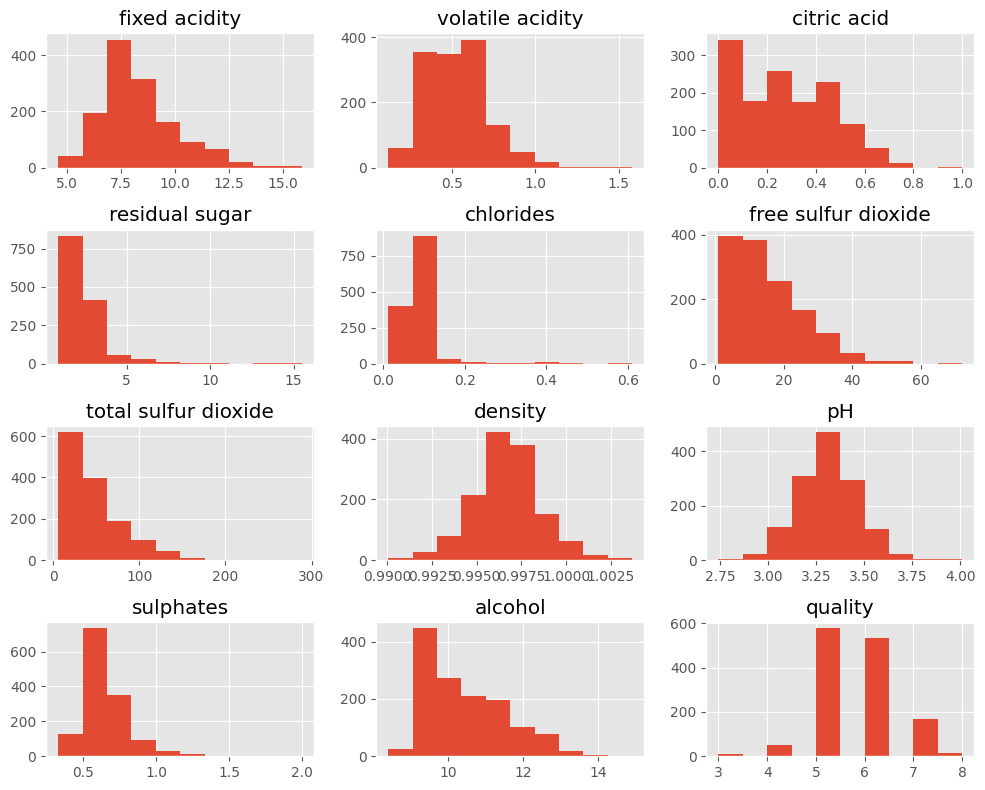

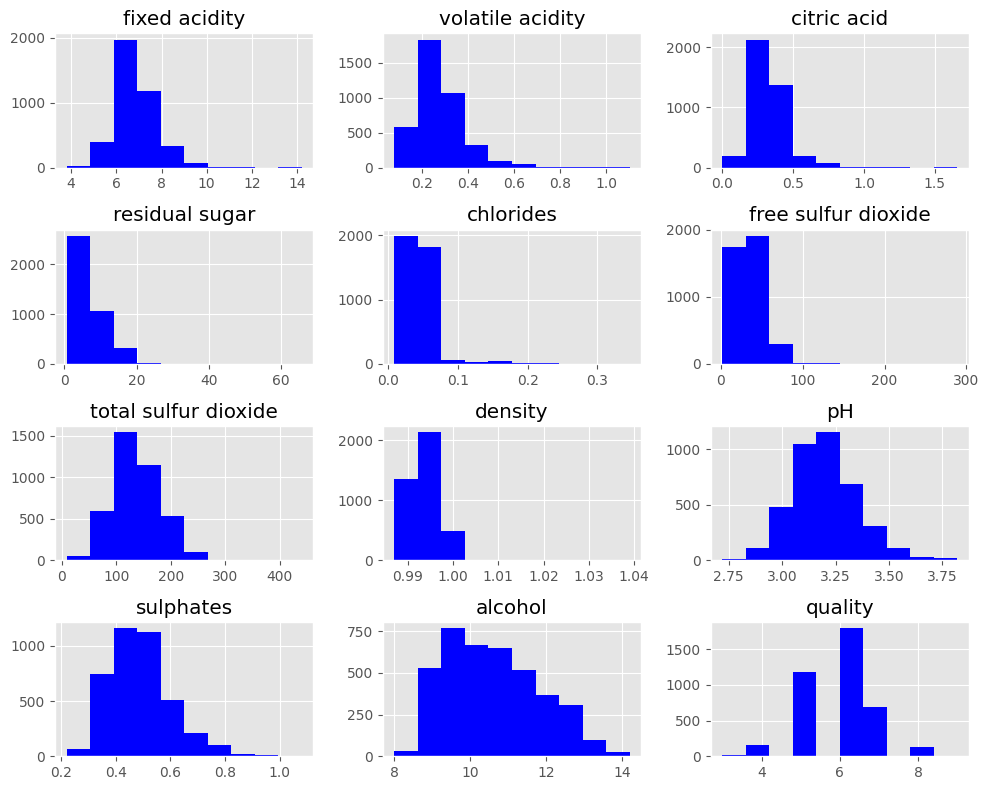

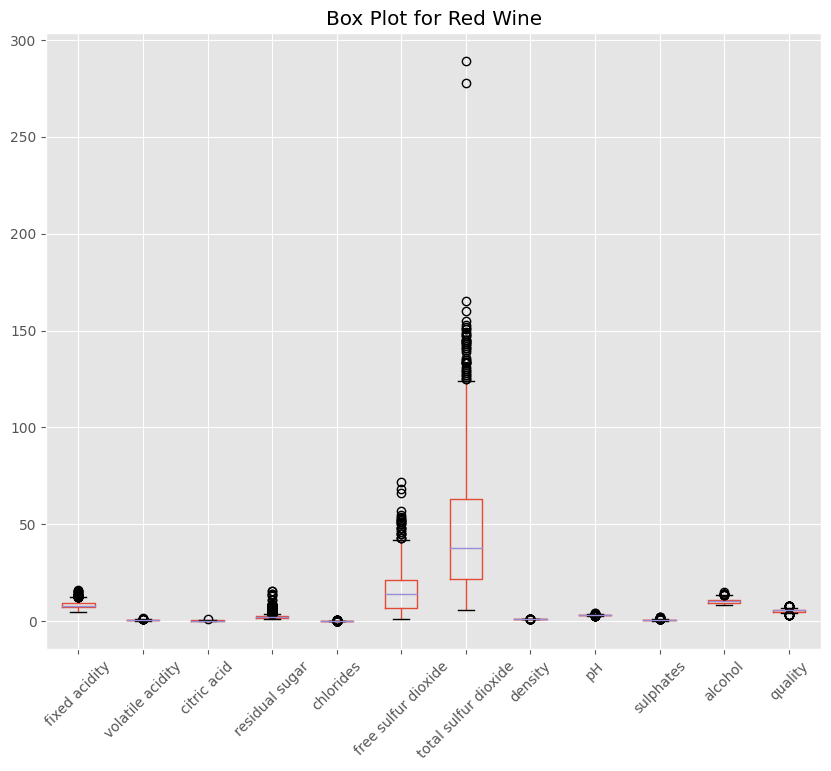

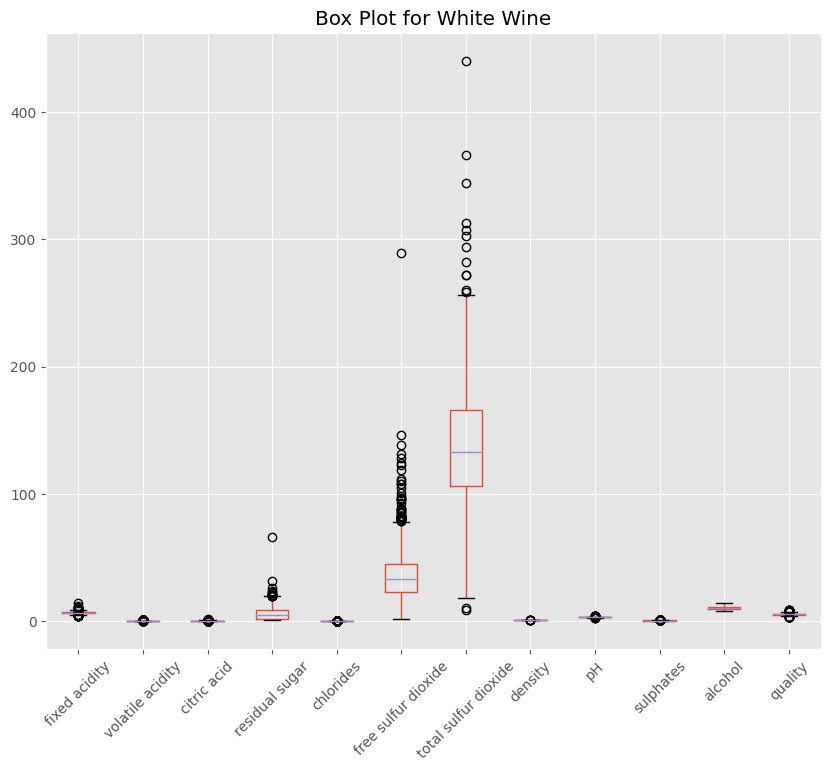

In [ ]:


# Plot histograms for numerical columns
d_red.hist(figsize=(10, 8))
plt.tight_layout()
plt.show() # so the red histograms represent the columns of our red wine
d_white.hist(figsize=(10, 8), color='b')
plt.tight_layout()
plt.show()# the blue histograms represent columns of the white wine

# Plot box plots for numerical columns
d_red.boxplot(figsize=(10, 8))
plt.title('Box Plot for Red Wine')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability..thanks to ChatGPT
plt.show()
d_white.boxplot(figsize=(10, 8))
plt.title('Box Plot for White Wine')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability..thanks to ChatGPT
plt.show()



So far,the idea we are getting from our Box Plot is that all the variables are needed for predicting the value of our wine quality. We must get some further validation.Histograms tell us that the model is nicely spread without any problem of outliers

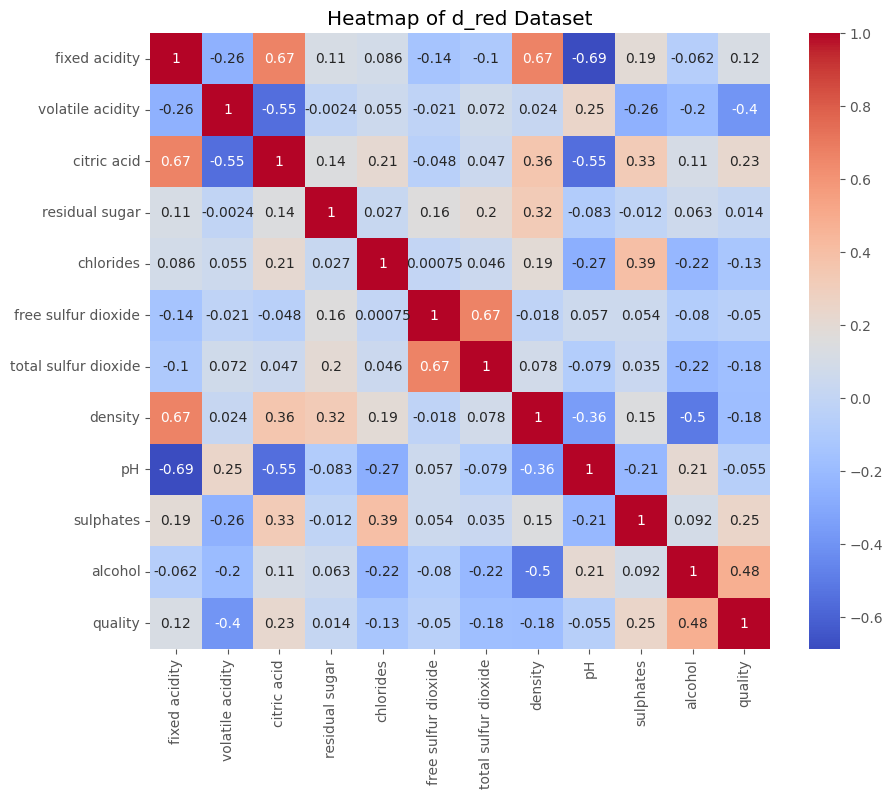

In [ ]:


# Assuming d_red is your DataFrame
plt.figure(figsize=(10, 8))
sns.heatmap(d_red.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of d_red Dataset')
plt.show()
# Assuming d_white is your DataFrame
plt.figure(figsize=(10, 8))
sns.heatmap(d_white.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of d_white Dataset')
plt.show()


This confirms are our earlier findings that none of the 11 variables can be dropped in predicting the quality. We require all 11, clearly shown from our correlation values.None have very high correlation values. Credit to **ChatGPT **for helping me with the syntax

# **The above concludes Question 1b**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
train_red, temp_test_red = train_test_split(d_red, test_size=0.2, random_state=42)
test_red, valid_red = train_test_split(temp_test_red, test_size=0.5, random_state=42)



scaler = preprocessing.StandardScaler() # for data normalization
cols_data = d_red.columns.drop('quality').values  # columns to be used for training
scaler.fit(train_red[cols_data])

train_red_X = pd.DataFrame(scaler.transform(train_red[cols_data]))
train_red_Y = pd.DataFrame(train_red['quality'])
test_red_X = pd.DataFrame(scaler.transform(test_red[cols_data]))
test_red_Y = pd.DataFrame(test_red['quality'])
valid_red_X = pd.DataFrame(scaler.transform(valid_red[cols_data]))
valid_red_Y = pd.DataFrame(valid_red['quality'])
# doing this for red wine data
train_white, temp_test_white = train_test_split(d_white, test_size=0.2, random_state=42)
test_white , valid_white = train_test_split(temp_test_white, test_size=0.5, random_state=42)
scaler = preprocessing.StandardScaler() # for data normalization
cols_data = d_white.columns.drop('quality').values  # columns to be used for training
scaler.fit(train_white[cols_data])

train_white_X = pd.DataFrame(scaler.transform(train_white[cols_data]))
train_white_Y = pd.DataFrame(train_white['quality'])
test_white_X = pd.DataFrame(scaler.transform(test_white[cols_data]))
test_white_Y = pd.DataFrame(test_white['quality'])
valid_white_X = pd.DataFrame(scaler.transform(valid_red[cols_data]))
valid_white_Y = pd.DataFrame(valid_red['quality'])
# now doing this for white wine data

# Preprocessing data and normalizing  the data set and make it zero mean and unit variance is very important as explained below











This is the usual. splitting data into test and train data so that we can apply our models on the same. We follow the 80-20 rule.Preprocessing the data is important as all our features might have different units.We split into test and validation data also for reasons that will be explained below.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
hyperparameters = {'n_estimators': [10, 50, 100, 150, 200], 'max_depth': [None, 3, 6, 10, 20, 30]}
best_val_mse = float('inf')
best_hyperparameters = {}
for n_estimators in hyperparameters['n_estimators']:
    for max_depth in hyperparameters['max_depth']:
        rf_regressor_red = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf_regressor_red.fit(train_red_X, train_red_Y.values.ravel())
        Y_val_pred = rf_regressor_red.predict(valid_red_X)
        val_mse = mean_squared_error(valid_red_Y, Y_val_pred)
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth}
print("Best validation MSE:", best_val_mse)
print("Best hyperparameters:", best_hyperparameters)




Best validation MSE: 0.395047886444161
Best hyperparameters: {'n_estimators': 50, 'max_depth': 20}


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define the best hyperparameters obtained from the validation set
best_hyperparameters = {'n_estimators': 50, 'max_depth': 20}
# Instantiate the RandomForestRegressor with the best hyperparameters
best_rf_regressor_red = RandomForestRegressor(n_estimators=best_hyperparameters['n_estimators'],
                                              max_depth=best_hyperparameters['max_depth'],
                                              random_state=42)
# Fit the best model to the training data
best_rf_regressor_red.fit(train_red_X, train_red_Y.values.ravel())
# Predict on the test set using the best model
y_pred_test = best_rf_regressor_red.predict(test_red_X)
# Evaluate the performance of the best model
mse_test = mean_squared_error(test_red_Y, y_pred_test)
print("Mean Squared Error on Test Set with Best Model:", mse_test)


Mean Squared Error on Test Set with Best Model: 0.3527801470588235


We have applied random forest regressor to red wine.Also, we have varied 2 hyperparameters i.e n_estimators and max depth and found the best value of the same. ChatGPT really helped me with all the syntaxes as I was finding it very difficult to implement the same. The validation and test MSE do not differ substantially and hence this is an acceptable model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
hyperparameters = {'n_estimators': [10, 50, 100, 150, 200], 'max_depth': [None, 3, 6, 10, 20, 30]}
best_val_mse = float('inf')
best_hyperparameters = {}
for n_estimators in hyperparameters['n_estimators']:
    for max_depth in hyperparameters['max_depth']:
        rf_regressor_white = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf_regressor_white.fit(train_white_X, train_white_Y.values.ravel())
        Y_val_pred = rf_regressor_white.predict(valid_white_X)
        val_mse = mean_squared_error(valid_white_Y, Y_val_pred)
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth}
print("Best validation MSE:", best_val_mse)
print("Best hyperparameters:", best_hyperparameters)


Best validation MSE: 0.558013871420036
Best hyperparameters: {'n_estimators': 150, 'max_depth': 3}


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# Define the best hyperparameters obtained from the validation set
best_hyperparameters = {'n_estimators': 150, 'max_depth': 3}
# Instantiate the RandomForestRegressor with the best hyperparameters
best_rf_regressor_white = RandomForestRegressor(n_estimators=best_hyperparameters['n_estimators'],
                                              max_depth=best_hyperparameters['max_depth'],
                                              random_state=42)
# Fit the best model to the training data
best_rf_regressor_white.fit(train_white_X, train_white_Y.values.ravel())
# Predict on the test set using the best model
y_pred_test = best_rf_regressor_white.predict(test_white_X)
# Evaluate the performance of the best model
mse_test = mean_squared_error(test_white_Y, y_pred_test)
print("Mean Squared Error on Test Set with Best Model:", mse_test)

Mean Squared Error on Test Set with Best Model: 0.5684557521698853


We have applied random forest classification to white wine .Also, we have varied 2 hyperparameters i.e n_estimators and max depth and found the best value of the same. ChatGPT really helped me with all the syntaxes as I was finding it very difficult to implement the same. Clearly here, the validation and test MSE do not differ substantially and hence this is an acceptable model.

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import sys
hyperparameters = {'C': [0.1,1,10, 100], 'epsilon': [0.0001,0.001,0.01, 0.1, 1]}
best_validation_mse = sys.float_info.max
best_hyperparameters = {}
train_red_Y_one = train_red_Y.values.ravel()
for C in hyperparameters['C']:
    for epsilon in hyperparameters['epsilon']:
        svm_rbf_red = SVR(kernel='rbf', C=C, epsilon=epsilon)
        svm_rbf_red.fit(train_red_X, train_red_Y_one)
        Y_val_pred = svm_rbf_red.predict(valid_red_X)
        validation_mse = mean_squared_error(Y_val_pred, valid_red_Y)
        if validation_mse < best_validation_mse:
            best_validation_mse = validation_mse
            best_hyperparameters = {'C': C, 'epsilon': epsilon}
print("Best Validation MSE:", best_validation_mse)
print("Best Hyperparameters:", best_hyperparameters)


Best Validation MSE: 0.4137794945268183
Best Hyperparameters: {'C': 1, 'epsilon': 0.01}


In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
# Instantiate the SVR with the best hyperparameters found
best_svr_regressor_red = SVR(kernel='rbf', C=best_hyperparameters['C'], epsilon=best_hyperparameters['epsilon'])
best_svr_regressor_red.fit(train_red_X, train_red_Y_one)
# Predict on the test set using the best model
y_pred_test = best_svr_regressor_red.predict(test_red_X)
# Evaluate the performance of the best model on the test set
mse_test = mean_squared_error(test_red_Y, y_pred_test)
print("Mean Squared Error on Test Set with Best Model:", mse_test)


Mean Squared Error on Test Set with Best Model: 0.37074005153249406


For red wine we are using SV regressor using RBF kernel above. We varied 2 hyperparameters and found the best ones for us. ChatGPT greatly helped me with the libraries and coding part with blocks and syntaxes. Once again, the validation and test MSE do not differ substantially and hence this is an acceptable model.

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import sys
hyperparameters = {'C': [0.1,1,10, 100], 'epsilon': [0.0001,0.001,0.01, 0.1, 1]}
best_validation_mse = sys.float_info.max
best_hyperparameters = {}
train_white_Y_one = train_white_Y.values.ravel()
for C in hyperparameters['C']:
    for epsilon in hyperparameters['epsilon']:
        svm_rbf_white = SVR(kernel='rbf', C=C, epsilon=epsilon)
        svm_rbf_white.fit(train_white_X, train_white_Y_one)
        Y_val_pred = svm_rbf_white.predict(valid_white_X)
        validation_mse = mean_squared_error(Y_val_pred, valid_white_Y)
        if validation_mse < best_validation_mse:
            best_validation_mse = validation_mse
            best_hyperparameters = {'C': C, 'epsilon': epsilon}
print("Best Validation MSE:", best_validation_mse)
print("Best Hyperparameters:", best_hyperparameters)


Best Validation MSE: 0.6586066659031813
Best Hyperparameters: {'C': 0.1, 'epsilon': 0.01}


In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
# Instantiate the SVR with the best hyperparameters found
best_svr_regressor_white = SVR(kernel='rbf', C=best_hyperparameters['C'], epsilon=best_hyperparameters['epsilon'])
best_svr_regressor_white.fit(train_white_X, train_white_Y_one)
# Predict on the test set using the best model
y_pred_test = best_svr_regressor_white.predict(test_white_X)
# Evaluate the performance of the best model on the test set
mse_test = mean_squared_error(test_white_Y, y_pred_test)
print("Mean Squared Error on Test Set with Best Model:", mse_test)


Mean Squared Error on Test Set with Best Model: 0.5636431946808482


For white wine we are using SV regressor using RBF kernel above. We varied 2 hyperparameters and found the best ones for us. ChatGPT greatly helped me with the libraries and coding part with blocks and syntaxes.Here also the validation and test MSE do not differ a lot, though the difference is higher than in previous models. We will see the downside to this in question 1e.

One reason we are breaking the data into validation data as well is to get our best hyperparameters using validation data and then using them to get our best test MSE.

# **With this we conclude Question 1c)**

In [ ]:
# Get feature names and their importances
feature_names = train_red.columns.drop('quality')
feature_importances = best_rf_regressor_red.feature_importances_
# Create a DataFrame to store feature names and importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
# Sort features by importance value
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
# Print feature importances
print("Random Forest Feature Importances:")
print(feature_importances_df)



Random Forest Feature Importances:
                 Feature  Importance
10               alcohol    0.272652
9              sulphates    0.151100
1       volatile acidity    0.108390
6   total sulfur dioxide    0.077636
4              chlorides    0.070043
8                     pH    0.061484
3         residual sugar    0.058068
7                density    0.052488
0          fixed acidity    0.052336
2            citric acid    0.048978
5    free sulfur dioxide    0.046824


Here we get the order of importance for the features in red wine using random forest.ChatGPT helped me with the code and also to understand the nuances of this concept

In [ ]:
# Get feature names and their importances
feature_names = train_white.columns.drop('quality')
feature_importances = best_rf_regressor_white.feature_importances_
# Create a DataFrame to store feature names and importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
# Sort features by importance value
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
# Print feature importances
print("Random Forest Feature Importances:")
print(feature_importances_df)



Random Forest Feature Importances:
                 Feature  Importance
10               alcohol    0.239743
1       volatile acidity    0.124724
5    free sulfur dioxide    0.117955
6   total sulfur dioxide    0.070105
8                     pH    0.069818
3         residual sugar    0.069288
9              sulphates    0.062648
0          fixed acidity    0.062485
4              chlorides    0.062387
7                density    0.061005
2            citric acid    0.059842


Here we get the order of importance for the features in white wine using random forest.ChatGPT helped me with the code and also to understand the nuances of this concept. One very important point here is that
***it is not necessary that we will get the same order for red wine as it is clearly shown here. example sulphates is second most important in red wine but seventh for white wine ***

In [ ]:
# Get support vectors' coefficients
dual_coefficients = best_svr_regressor_red.support_vectors_
# Create a DataFrame to store support vectors' coefficients
dual_coefficients_df = pd.DataFrame(dual_coefficients, columns=feature_names)
# Print support vectors' coefficients
print("SVR (RBF Kernel) Support Vectors' Coefficients:")
print(dual_coefficients_df)
# Assuming dual_coefficients is obtained from best_svr_regressor_red.support_vectors_


SVR (RBF Kernel) Support Vectors' Coefficients:
      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          1.494753         -0.784347     1.011045       -0.526378   0.599272   
1          0.276351          0.861811    -0.063831       -0.665729  -0.009085   
2          0.044274          2.814880    -0.626861        2.399985  -0.313264   
3         -1.174128          0.108484    -0.626861       -0.526378  -0.232149   
4         -0.187802         -0.170525     0.601569        0.031024  -0.130756   
...             ...               ...          ...             ...        ...   
1012       0.276351          0.108484    -1.189891       -0.247677   0.619551   
1013      -1.116109         -0.784347     0.294461        0.518752  -0.860785   
1014       0.624466         -0.728545     1.011045       -0.038651  -0.029364   
1015       0.450408          0.387494    -1.394630       -0.456703  -0.617442   
1016      -1.464224         -1.342367    -0.063831       -0.5

Feature Importance Scores:
                 Feature  Importance
2            citric acid    0.866394
0          fixed acidity    0.820053
10               alcohol    0.804957
1       volatile acidity    0.783775
8                     pH    0.782098
5    free sulfur dioxide    0.778330
7                density    0.775851
6   total sulfur dioxide    0.707138
9              sulphates    0.674945
3         residual sugar    0.558104
4              chlorides    0.464616


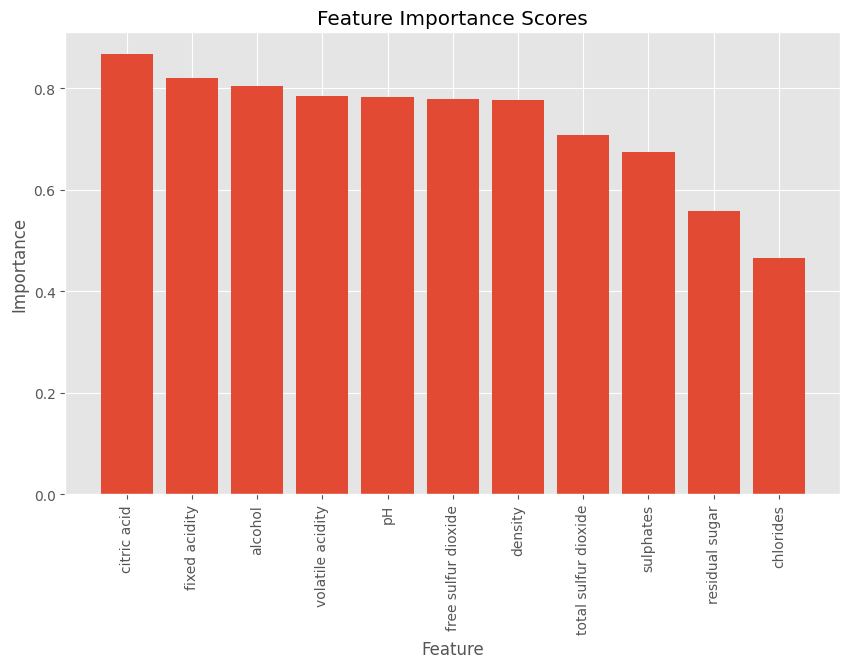

In [ ]:
# Take the absolute values of support vectors' coefficients
abs_dual_coefficients = np.abs(dual_coefficients)
# Calculate the average importance of each feature
feature_importance = abs_dual_coefficients.mean(axis=0)
# Create a DataFrame to store feature importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Print feature importance scores
print("Feature Importance Scores:")
print(feature_importance_df)
# Visualization: Bar plot of feature importance scores..the final frontier here
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance Scores')
plt.xticks(rotation=90)
plt.show()


Again, doing the same for sv regressor using RBF kernel is not simple. I consulted ChatGPT on what to do and it recommended me the method of **absolute dual coefficients**.It gives an account of the importance of our various features using a completely different metric where it calculates the dual coeffcients for each feature.

In [ ]:
# Get support vectors' coefficients
dual_coefficients1 = best_svr_regressor_white.support_vectors_
# Create a DataFrame to store support vectors' coefficients
dual_coefficients_df = pd.DataFrame(dual_coefficients1, columns=feature_names)
# Print support vectors' coefficients
print("SVR (RBF Kernel) Support Vectors' Coefficients:")
print(dual_coefficients_df)
# Assuming dual_coefficients is obtained from best_svr_regressor_red.support_vectors_


SVR (RBF Kernel) Support Vectors' Coefficients:
      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          0.515119         -1.076233     0.227731        0.340419  -0.813688   
1         -0.669188         -0.288777     0.895832        1.002071  -0.217212   
2          0.041396         -0.879369     0.144218       -0.924503  -0.446626   
3          0.988842          0.203384    -0.607396        2.432407   0.333383   
4         -0.432327          1.778296    -0.774421        0.982611   0.241617   
...             ...               ...          ...             ...        ...   
3307      -0.195465          0.203384     0.895832        2.393486   0.516914   
3308      -0.787619         -0.682505     1.563933        0.009594   0.058085   
3309       0.870412         -0.091913     1.563933       -0.632598  -0.125446   
3310      -0.669188         -0.387209    -0.356858        1.410739  -0.492509   
3311       1.462565         -0.091913     0.144218       -0.9

Feature Importance Scores:
                 Feature  Importance
10               alcohol    0.841000
3         residual sugar    0.836268
7                density    0.816662
6   total sulfur dioxide    0.805348
8                     pH    0.788273
5    free sulfur dioxide    0.787400
9              sulphates    0.780541
0          fixed acidity    0.771845
1       volatile acidity    0.725131
2            citric acid    0.699641
4              chlorides    0.527917


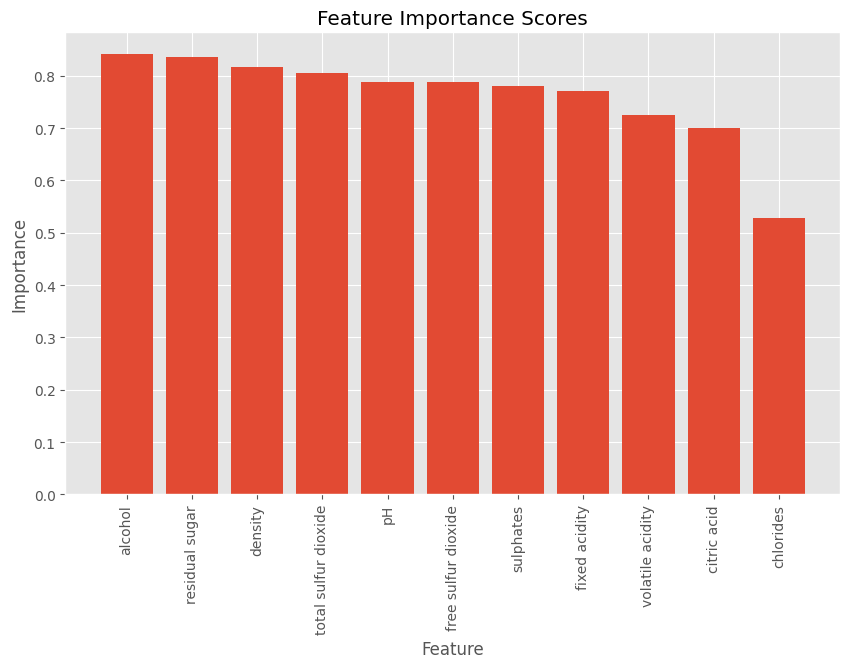

In [ ]:
# Take the absolute values of support vectors' coefficients
abs_dual_coefficients1 = np.abs(dual_coefficients1)
# Calculate the average importance of each feature
feature_importance = abs_dual_coefficients1.mean(axis=0)
# Create a DataFrame to store feature importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Print feature importance scores
print("Feature Importance Scores:")
print(feature_importance_df)
# Visualization: Bar plot of feature importance scores
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance Scores')
plt.xticks(rotation=90)
plt.show()


Again, doing the same for sv regressor using RBF kernel is not simple. I consulted ChatGPT on what to do and it recommended me the method of **absolute dual coefficients**.It gives an account of the importance of our various features using a completely different metric where it calculates the dual coeffcients for each feature. Note clearly the difference in order of importance for red and white wine. Alcohol is at the top for white wine but citric acid is on top for red wine.

We must also note that applying different model on same dataset is also giving different order of importance. ***The same variables might not be important for different models. ***Example, for red wine,random forest classifer :
Random Forest Feature Importances:
                 Feature  Importance
10               alcohol    0.272652
9              sulphates    0.151100
1       volatile acidity    0.108390
6   total sulfur dioxide    0.077636
4              chlorides    0.070043
8                     pH    0.061484
3         residual sugar    0.058068
7                density    0.052488
0          fixed acidity    0.052336
2            citric acid    0.048978
5    free sulfur dioxide    0.046824
for sv regressor order is
Feature Importance Scores:
                 Feature  Importance
2            citric acid    0.866394
0          fixed acidity    0.820053
10               alcohol    0.804957
1       volatile acidity    0.783775
8                     pH    0.782098
5    free sulfur dioxide    0.778330
7                density    0.775851
6   total sulfur dioxide    0.707138
9              sulphates    0.674945
3         residual sugar    0.558104
4              chlorides    0.464616

**clearly citric acid is most important for sv regressor but of little importance for random forest classifier. Sulphates is very important as per random forest classifer but not important for sv regressor!**

# **With this, we conclude our Question 1d**

In [ ]:
y_hat_red = best_rf_regressor_white.predict(test_red_X)
print(f"Mean Squared Error of White's model tested on red data using Random Forest: {mean_squared_error(y_hat_red, test_red_Y)}")

y_hat_red = best_svr_regressor_white.predict(test_red_X)
print(f"Mean Squared Error of White's model tested on red data using SVM: {mean_squared_error(y_hat_red, test_red_Y)}")

Mean Squared Error of White's model tested on red data using Random Forest: 0.5540689255017808
Mean Squared Error of White's model tested on red data using SVM: 0.5386401118589267


In [ ]:
y_hat_white = best_rf_regressor_red.predict(test_white_X)
print(f"Mean Squared Error of Red's model tested on white data using Random Forest: {mean_squared_error(y_hat_white, test_white_Y)}")

y_hat_white = best_svr_regressor_red.predict(test_white_X)
print(f"Mean Squared Error of Red's model tested on white data using SVM: {mean_squared_error(y_hat_white, test_white_Y)}")

Mean Squared Error of Red's model tested on white data using Random Forest: 0.7572512626262625
Mean Squared Error of Red's model tested on white data using SVM: 0.9018641827735359


**Model 1 (Random forest Trained on Red Wine)**

Validation MSE (Red Wine): 0.395
Test MSE (Red Wine): 0.353
Test MSE (White Wine): 0.757
Comments:

The **Random Forest regressor model trained on red wine** performs reasonably well on red wine test data with a slightly higher MSE than the validation set, indicating some generalization. However, its performance on **white wine data** is notably worse, suggesting **limited applicability across wine types**.

**Model 2 ( Random Forest regressor Trained on White Wine)**

Validation MSE (White Wine): 0.558
Test MSE (White Wine): 0.568
Test MSE (Red Wine): 0.554
Comments:

The model trained on white wine performs relatively well on white wine test data with a slightly lower MSE than the validation set. **However, its performance on red wine data is not significantly worse, indicating some degree of transferability between wine types.**

**Model 3 (SVR regressor model Trained on Red Wine)**

Validation MSE (Red Wine): 0.414
Test MSE (Red Wine): 0.371
Test MSE (White Wine): 0.902
Comments:

Similar to Model 1, this model exhibits reasonable performance on red wine test data but performs **significantly worse on white wine data, suggesting limited applicability across wine types.**

**Model 4 (SVR regressor model Trained on White Wine)**

Validation MSE (White Wine): 0.658
Test MSE (White Wine): 0.506
Test MSE (Red Wine): 0.538
Comments:

 this model shows relatively bad performance on white wine test data and slightly worse performance on red wine data, **indicating some level of transferability.**

**In summary, models trained on white wine data seem to have better transferability to red wine data compared to models trained on red wine data being applied to white wine data.** This suggests that there might be some underlying similarities between white and red wines that allow for some degree of cross-application of models, but the differences between the two types still affect predictive performance. Further investigation and feature analysis could provide insights into these differences and similarities.

# **Above we have discussed question 1e**

# **An approach to Question 4:**

In [ ]:
import os
import joblib
joblib.dump(best_rf_regressor_white, "rf_model_white.joblib")

['rf_model_white.joblib']

**forming a joblib file to be dumped seperately..The other app.py and app1.py files for red wine and white wine random forest regressor is enclosed in the zip file as the code has been written seperately as we do not have terminal in google colab** I would like to give credit to Chinta Madhav(21d070020) who really helped me with this question as google colab and python have some libraries out of sync. He also helped me formulate the code.

# **Now we are starting with Question 2**

In [ ]:
# Importing all necessary questions as shown in Question 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')

In [ ]:
data = pd.read_csv('Data_Cortex_Nuclear.csv')

# **With this, we conclude question 2a**

In [ ]:
# View the first few rows of the DataFrame
print(data.head())
# Get summary statistics of the data
print(data.describe())
# Check data types
print(data.dtypes)


  MouseID  DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N  \
0   309_1  0.503644  0.747193  0.430175  2.816329  5.990152  0.218830   
1   309_2  0.514617  0.689064  0.411770  2.789514  5.685038  0.211636   
2   309_3  0.509183  0.730247  0.418309  2.687201  5.622059  0.209011   
3   309_4  0.442107  0.617076  0.358626  2.466947  4.979503  0.222886   
4   309_5  0.434940  0.617430  0.358802  2.365785  4.718679  0.213106   

    pBRAF_N  pCAMKII_N   pCREB_N  ...   pCFOS_N     SYP_N  H3AcK18_N  \
0  0.177565   2.373744  0.232224  ...  0.108336  0.427099   0.114783   
1  0.172817   2.292150  0.226972  ...  0.104315  0.441581   0.111974   
2  0.175722   2.283337  0.230247  ...  0.106219  0.435777   0.111883   
3  0.176463   2.152301  0.207004  ...  0.111262  0.391691   0.130405   
4  0.173627   2.134014  0.192158  ...  0.110694  0.434154   0.118481   

     EGR1_N  H3MeK4_N    CaNA_N  Genotype  Treatment  Behavior   class  
0  0.131790  0.128186  1.675652   Control  Memantine   

In [ ]:
# Print the column names of your DataFrame
print("Column Names:", data.columns)
data['Genotype'] = data['Genotype'].replace('Control', 0)
data['Genotype'] = data['Genotype'].replace('Ts65Dn', 1)
data['Genotype'] = data['Genotype'].astype(int)


Column Names: Index(['MouseID', 'DYRK1A_N', 'ITSN1_N', 'BDNF_N', 'NR1_N', 'NR2A_N', 'pAKT_N',
       'pBRAF_N', 'pCAMKII_N', 'pCREB_N', 'pELK_N', 'pERK_N', 'pJNK_N',
       'PKCA_N', 'pMEK_N', 'pNR1_N', 'pNR2A_N', 'pNR2B_N', 'pPKCAB_N',
       'pRSK_N', 'AKT_N', 'BRAF_N', 'CAMKII_N', 'CREB_N', 'ELK_N', 'ERK_N',
       'GSK3B_N', 'JNK_N', 'MEK_N', 'TRKA_N', 'RSK_N', 'APP_N', 'Bcatenin_N',
       'SOD1_N', 'MTOR_N', 'P38_N', 'pMTOR_N', 'DSCR1_N', 'AMPKA_N', 'NR2B_N',
       'pNUMB_N', 'RAPTOR_N', 'TIAM1_N', 'pP70S6_N', 'NUMB_N', 'P70S6_N',
       'pGSK3B_N', 'pPKCG_N', 'CDK5_N', 'S6_N', 'ADARB1_N', 'AcetylH3K9_N',
       'RRP1_N', 'BAX_N', 'ARC_N', 'ERBB4_N', 'nNOS_N', 'Tau_N', 'GFAP_N',
       'GluR3_N', 'GluR4_N', 'IL1B_N', 'P3525_N', 'pCASP9_N', 'PSD95_N',
       'SNCA_N', 'Ubiquitin_N', 'pGSK3B_Tyr216_N', 'SHH_N', 'BAD_N', 'BCL2_N',
       'pS6_N', 'pCFOS_N', 'SYP_N', 'H3AcK18_N', 'EGR1_N', 'H3MeK4_N',
       'CaNA_N', 'Genotype', 'Treatment', 'Behavior', 'class'],
      dtype='objec

We are encoding the 2 possible genotypes by 0 and 1. This was recommended to me by my good friend Vedant Yadav(210110116) who also helped me with the layout.

In [ ]:
# Assuming data is your DataFrame
plt.figure(figsize=(200, 160))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of data_cortex_nuclear Dataset')
plt.show()


<ipython-input-41-d2c161195d0b>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm')


In [ ]:

data = data.drop(['MouseID', 'Treatment', 'Behavior', 'class'], axis = 1).copy()

We are dropping MouseID as clearly it is of no use to predict the Genotype. Also, since we are predicting only the genotype, we do not need treatment, behavior and class and hence they can be dropped too.

In [ ]:
# Extract pairs of variables with correlation greater than 0.9...decided on 0.9 after numerous iterations on different values like 0.8, 0.85,0.95
high_corr_pairs = [(data.columns[i], data.columns[j], data.corr().iloc[i, j])
                   for i in range(len(data.columns))
                   for j in range(i+1, len(data.columns))
                   if abs(data.corr().iloc[i, j]) > 0.9]
# Print pairs of variables with correlation greater than 0.9
for pair in high_corr_pairs:
    print(f"Variables '{pair[0]}' and '{pair[1]}' have correlation {pair[2]}")


Variables 'DYRK1A_N' and 'ITSN1_N' have correlation 0.9595117712737146
Variables 'DYRK1A_N' and 'pERK_N' have correlation 0.9457193906546576
Variables 'DYRK1A_N' and 'BRAF_N' have correlation 0.9595779012202321
Variables 'ITSN1_N' and 'pERK_N' have correlation 0.9062887297003304
Variables 'ITSN1_N' and 'BRAF_N' have correlation 0.9176078424598717
Variables 'NR1_N' and 'pNR1_N' have correlation 0.9478716685541183
Variables 'NR1_N' and 'Bcatenin_N' have correlation 0.9146104019102187
Variables 'pERK_N' and 'BRAF_N' have correlation 0.9269841542416365
Variables 'pNR1_N' and 'pNR2B_N' have correlation 0.9065036197767554
Variables 'ARC_N' and 'pS6_N' have correlation 1.0


In [ ]:
data = data.drop(['ITSN1_N', 'pERK_N', 'BRAF_N', 'Bcatenin_N','pNR1_N','pS6_N'], axis = 1).copy()

Variables 'ARC_N' and 'pS6_N' have correlation 1.0, so we can remove one of the two in order to prevent future mismatches. I am also removing features if the correlation is above 0.9. I used **ChatGPT** for the code layout

so we have dropped the columns that we will not be requiring for our prediction of the genotype.

In [ ]:
print("Column Names:", data.columns)

Column Names: Index(['DYRK1A_N', 'BDNF_N', 'NR1_N', 'NR2A_N', 'pAKT_N', 'pBRAF_N',
       'pCAMKII_N', 'pCREB_N', 'pELK_N', 'pJNK_N', 'PKCA_N', 'pMEK_N',
       'pNR2A_N', 'pNR2B_N', 'pPKCAB_N', 'pRSK_N', 'AKT_N', 'CAMKII_N',
       'CREB_N', 'ELK_N', 'ERK_N', 'GSK3B_N', 'JNK_N', 'MEK_N', 'TRKA_N',
       'RSK_N', 'APP_N', 'SOD1_N', 'MTOR_N', 'P38_N', 'pMTOR_N', 'DSCR1_N',
       'AMPKA_N', 'NR2B_N', 'pNUMB_N', 'RAPTOR_N', 'TIAM1_N', 'pP70S6_N',
       'NUMB_N', 'P70S6_N', 'pGSK3B_N', 'pPKCG_N', 'CDK5_N', 'S6_N',
       'ADARB1_N', 'AcetylH3K9_N', 'RRP1_N', 'BAX_N', 'ARC_N', 'ERBB4_N',
       'nNOS_N', 'Tau_N', 'GFAP_N', 'GluR3_N', 'GluR4_N', 'IL1B_N', 'P3525_N',
       'pCASP9_N', 'PSD95_N', 'SNCA_N', 'Ubiquitin_N', 'pGSK3B_Tyr216_N',
       'SHH_N', 'BAD_N', 'BCL2_N', 'pCFOS_N', 'SYP_N', 'H3AcK18_N', 'EGR1_N',
       'H3MeK4_N', 'CaNA_N', 'Genotype'],
      dtype='object')


We move forward with the above as our final features

In [ ]:
# Make list of columns which have missing values
cols_with_null = []
for cols in data.columns:
  if (data[cols].isna().sum() > 0):
    cols_with_null.append(cols)
for cols in cols_with_null:
  data[cols] = pd.to_numeric(data[cols], errors='coerce')

In [ ]:
# Setup scikit imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter = 10, random_state = 0)
data_imputed = imp.fit_transform(data)
data = pd.DataFrame(data_imputed, columns = data.columns).copy()
data.isna().sum()

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


DYRK1A_N           0
BDNF_N             0
NR1_N              0
NR2A_N             0
pAKT_N             0
pBRAF_N            0
pCAMKII_N          0
pCREB_N            0
pELK_N             0
pJNK_N             0
PKCA_N             0
pMEK_N             0
pNR2A_N            0
pNR2B_N            0
pPKCAB_N           0
pRSK_N             0
AKT_N              0
CAMKII_N           0
CREB_N             0
ELK_N              0
ERK_N              0
GSK3B_N            0
JNK_N              0
MEK_N              0
TRKA_N             0
RSK_N              0
APP_N              0
SOD1_N             0
MTOR_N             0
P38_N              0
pMTOR_N            0
DSCR1_N            0
AMPKA_N            0
NR2B_N             0
pNUMB_N            0
RAPTOR_N           0
TIAM1_N            0
pP70S6_N           0
NUMB_N             0
P70S6_N            0
pGSK3B_N           0
pPKCG_N            0
CDK5_N             0
S6_N               0
ADARB1_N           0
AcetylH3K9_N       0
RRP1_N             0
BAX_N        

Again, credits to ChatGPT here for giving me a layout for finding columns that have null values so that we can impute 0 in those places.Thanks to **Amit Sethi** sir for the handout which gave a very basic way to import iterative imputer from the sklearn.experimental library. Then when I printed the null values in each column, I get 0 null values in each column.

# With this, we conclude **Question 2b**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
scaler = preprocessing.StandardScaler() # for data normalization...a very important step
cols_data = data.columns.drop('Genotype').values  # columns to be used for training
scaler.fit(train_data[cols_data])
train_data_X = pd.DataFrame(scaler.transform(train_data[cols_data]))
train_data_Y = pd.DataFrame(train_data['Genotype'])
test_data_X = pd.DataFrame(scaler.transform(test_data[cols_data]))
test_data_Y = pd.DataFrame(test_data['Genotype'])


Now preparing the data by splitting into test and train data above and hence we can apply our models now! Once again, I was getting syntax errors that were rectified by ChatGPT!

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import pandas as pd


In [ ]:



# Assuming train_data_X, train_data_Y, test_data_X, test_data_Y are defined..which they are clearly defined above
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],'max_depth': [None, 10, 20, 30]  # Varying the number of trees and the depth of the trees..arbitary values recommended by ChatGPT1
}
# Instantiating our RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
# Fit the grid search to the training data
grid_search.fit(train_data_X, train_data_Y.values.ravel())
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'n_estimators': 200}


We now get our best hyperparameters to now apply it on our Random Classifier Model and find our best model accuracy.I had written a very long code for the same, ChatGPT helped me optimize the same.

In [ ]:
# Re-train the model using the best hyperparameters..
best_rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
best_rf_classifier.fit(train_data_X, train_data_Y.values.ravel())
# Predicting on the test set using the best model...
y_pred_best = best_rf_classifier.predict(test_data_X)
# Calculating accuracy of the best model..the final frontier
accuracy_best = accuracy_score(test_data_Y, y_pred_best)
print("Best Model Accuracy:", accuracy_best)

Best Model Accuracy: 0.9907407407407407


So we get our best model accuracy here for the random forest classifer case

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing



# Define the SVC classifier with RBF kernel
svc_classifier = SVC(kernel='rbf')  # Default hyperparameters..as specified in the question

In [ ]:



# Define the hyperparameters grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter..our first hyperparameter
    'gamma': [0.1, 1, 10, 100]  # Kernel coefficient our second hyperparameter
}
# Instantiate the grid search model..recommended to me by ChatGPT
grid_search = GridSearchCV(estimator=svc_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
# Fit the grid search to the data
grid_search.fit(train_data_X, train_data_Y.values.ravel())# this was recommended by google collab itself..using ravel
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)



Best Hyperparameters: {'C': 10, 'gamma': 0.1}


In [ ]:
# Re-train the model using the best hyperparameters
best_svc_classifier = SVC(kernel='rbf', C=10,gamma=0.1)
best_svc_classifier.fit(train_data_X, train_data_Y)
# Predicting on the test set using the best model
y_pred_best = best_svc_classifier.predict(test_data_X)
# Calculating accuracy of the best model
accuracy_best = accuracy_score(test_data_Y, y_pred_best)
print("Best Model Accuracy:", accuracy_best)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Model Accuracy: 0.9953703703703703


So we get our best model accuracy for SV classifer using rbf kernel..thanks to ChatGPT i was able to optimize the code I had written before

# **With this, we conclude question 2c**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
import pandas as pd
# Initialize the RandomForestClassifier..our best model
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
# Initialize the RFECV object with the chosen model and scoring metric..recommended by ChatGPT
rfecv = RFECV(estimator=rf_classifier, cv=5, scoring='accuracy')
# Fit the RFECV object to the training data..
rfecv.fit(train_data_X, train_data_Y.values.ravel())
# Access the selected features..those that will contribute
selected_features = rfecv.support_
# Transform the data using the selected features
train_data_X_selected = train_data_X.iloc[:, selected_features]
test_data_X_selected = test_data_X.iloc[:, selected_features]
# Retrain the model on the transformed data
rf_classifier.fit(train_data_X_selected, train_data_Y.values.ravel())
# Predict on the test set
y_pred_test = rf_classifier.predict(test_data_X_selected)
# Evaluate the performance of the model with selected features on the test set
accuracy_test = accuracy_score(test_data_Y, y_pred_test)
print("Accuracy on Test Set with Selected Features:", accuracy_test)


Accuracy on Test Set with Selected Features: 0.9861111111111112


feature selection or recursive feature elimination does not always guarantee high accuracy. While feature selection(or recursion) aims to improve model performance by selecting the most relevant features and reducing dimensionality, its effectiveness depends on various factors like quality of features, overfitting,choice of feature selection model.Here, my accuracy doesnt have any substantial change as I was getting an accuracy of 0.9907 before and am getting accuracy of 0.9861 right now.

In [ ]:
# Fit the RFECV object to the training data
rfecv.fit(train_data_X, train_data_Y.values.ravel())
# Access the selected features..moment of truth
selected_features = train_data_X.columns[rfecv.support_]
print("Selected Features:",rfecv.support_)
print(selected_features)


Selected Features: [ True  True  True  True  True False  True  True  True False  True False
  True False  True False False  True False False  True  True  True False
  True False  True  True  True  True  True  True  True  True  True  True
  True  True False False  True  True False  True  True  True  True False
  True False False  True False  True False  True False  True  True False
  True  True False False False False  True  True False  True  True]
Int64Index([ 0,  1,  2,  3,  4,  6,  7,  8, 10, 12, 14, 17, 20, 21, 22, 24, 26,
            27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 43, 44, 45, 46,
            48, 51, 53, 55, 57, 58, 60, 61, 66, 67, 69, 70],
           dtype='int64')


This helps me understand which features were taken after selection. Thanks to **Amit sethi** sir for providing a handout for us to understand this concept and for **ChatGPT** for helping me with various syntaxes.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
# Apply PCA for dimensionality reduction...complete credit to ChatGPT for helping me understand the same.
pca = PCA(n_components=10)  # Adjust the number of components as needed..10 as I like the number!
X_train_pca = pca.fit_transform(train_data_X)
X_test_pca = pca.transform(test_data_X)
# Initialize the SVC model with RBF kernel
svm_classifier = SVC(kernel='rbf', C=10, gamma=0.1)
# Fit the SVC model on the reduced dimensionality data
svm_classifier.fit(X_train_pca, train_data_Y.values.ravel())
# Predict on the test set
y_pred_test = svm_classifier.predict(X_test_pca)
# Evaluate the performance of the model
accuracy_test = accuracy_score(test_data_Y, y_pred_test)
print("Accuracy on Test Set with PCA:", accuracy_test)


Accuracy on Test Set with PCA: 0.9814814814814815


It is not straightforward to do feature selection for SVC using rbf kernel. We have options for linear svc kernels. So i had to consult ChatGPT for the same. It recommended me to use PCA for dimension reduction and I got an accuracy of0.9814 with it. It is similar to the accuracy I was getting before feature selection i.e 0.995. Again, removing some features recursively do not always guarantee improvement.

In [ ]:
# Get the indices of the selected principal components
selected_components = pca.components_
# Print the selected principal components
print("Selected Principal Components:")
for component_idx, component in enumerate(selected_components):
    print(f"Component {component_idx + 1}: {component}")


Selected Principal Components:
Component 1: [ 0.04267442  0.20266922  0.19804536  0.18158459  0.13851588  0.14503056
  0.1074734   0.17788795  0.0881288   0.18525507  0.16319541  0.17315614
  0.1511512   0.19654772  0.09062476  0.10340751  0.18639503  0.1728225
  0.12937027  0.1688933   0.15983754  0.12277286  0.18070739  0.2067643
  0.19813843  0.12666613  0.1399522   0.0558119   0.14272798  0.06378527
  0.16403842  0.12901833  0.17114095  0.16816937  0.13980545  0.13009316
  0.15189679  0.01768748  0.09362091  0.08863924  0.05888734  0.00787925
  0.08680625  0.00895004  0.13830079 -0.01959415  0.01172667  0.11080136
  0.09365296  0.09666816  0.08558057  0.00328765  0.01078765 -0.00167969
  0.03820919 -0.01397052  0.05362889  0.06509837  0.06788501  0.00741307
  0.09615875  0.03629781 -0.01240554 -0.02076396 -0.00437029 -0.04675685
  0.13749529 -0.02612175 -0.02263455 -0.0260365   0.01604768]
Component 2: [-1.46259986e-01 -6.28158199e-02 -1.01076488e-01 -1.16538912e-01
  1.49011007e-0

This again prints the indices of each component with the remaining feaures, sort of a correlation between them, negative or positive. This gives us an overview. This was again recommended to me by **ChatGPT**.

# **With this, we complete question 2d and question 2 as well**

Question 2.. a new approach!..As Amit Sethi Sir mentioned in MS teams to predict class instead of genotype..so tried that below.

In [ ]:
# Importing all necessary questions as shown in Question 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')

In [ ]:
data = pd.read_csv('Data_Cortex_Nuclear.csv')

In [ ]:
# Print the column names of your DataFrame
print("Column Names:", data.columns)
"""
data['Genotype'] = data['Genotype'].replace('Control', 0)
data['Genotype'] = data['Genotype'].replace('Ts65Dn', 1)
data['Genotype'] = data['Genotype'].astype(int)

data['Treatment'] = data['Treatment'].replace('Memantine', 0)
data['Treatment'] = data['Treatment'].replace('Saline', 1)
data['Treatment'] = data['Treatment'].astype(int)

data['Behavior'] = data['Behavior'].replace('C/S', 0)
data['Behavior'] = data['Behavior'].replace('S/C', 1)
data['Behavior'] = data['Behavior'].astype(int)
"""

data['class'] = data['class'].replace('c-CS-m', 0)
data['class'] = data['class'].replace('c-SC-m', 1)
data['class'] = data['class'].replace('c-CS-s', 2)
data['class'] = data['class'].replace('c-SC-s', 3)
data['class'] = data['class'].replace('t-CS-m', 4)
data['class'] = data['class'].replace('t-SC-m', 5)
data['class'] = data['class'].replace('t-CS-s', 6)
data['class'] = data['class'].replace('t-SC-s', 7)
data['class'] = data['class'].astype(int)

Column Names: Index(['MouseID', 'DYRK1A_N', 'ITSN1_N', 'BDNF_N', 'NR1_N', 'NR2A_N', 'pAKT_N',
       'pBRAF_N', 'pCAMKII_N', 'pCREB_N', 'pELK_N', 'pERK_N', 'pJNK_N',
       'PKCA_N', 'pMEK_N', 'pNR1_N', 'pNR2A_N', 'pNR2B_N', 'pPKCAB_N',
       'pRSK_N', 'AKT_N', 'BRAF_N', 'CAMKII_N', 'CREB_N', 'ELK_N', 'ERK_N',
       'GSK3B_N', 'JNK_N', 'MEK_N', 'TRKA_N', 'RSK_N', 'APP_N', 'Bcatenin_N',
       'SOD1_N', 'MTOR_N', 'P38_N', 'pMTOR_N', 'DSCR1_N', 'AMPKA_N', 'NR2B_N',
       'pNUMB_N', 'RAPTOR_N', 'TIAM1_N', 'pP70S6_N', 'NUMB_N', 'P70S6_N',
       'pGSK3B_N', 'pPKCG_N', 'CDK5_N', 'S6_N', 'ADARB1_N', 'AcetylH3K9_N',
       'RRP1_N', 'BAX_N', 'ARC_N', 'ERBB4_N', 'nNOS_N', 'Tau_N', 'GFAP_N',
       'GluR3_N', 'GluR4_N', 'IL1B_N', 'P3525_N', 'pCASP9_N', 'PSD95_N',
       'SNCA_N', 'Ubiquitin_N', 'pGSK3B_Tyr216_N', 'SHH_N', 'BAD_N', 'BCL2_N',
       'pS6_N', 'pCFOS_N', 'SYP_N', 'H3AcK18_N', 'EGR1_N', 'H3MeK4_N',
       'CaNA_N', 'Genotype', 'Treatment', 'Behavior', 'class'],
      dtype='objec

In [ ]:
data = data.drop(['MouseID', 'Treatment', 'Behavior', 'Genotype'], axis = 1).copy()

Class to be predicted so we can drop the others.

In [ ]:
data = data.drop(['ITSN1_N', 'pERK_N', 'BRAF_N', 'Bcatenin_N','pNR1_N','pS6_N'], axis = 1).copy()

Again, from above we know the correlation between variables and those dropped variables remain the same.

In [ ]:
# Make list of columns which have missing values
cols_with_null = []
for cols in data.columns:
  if (data[cols].isna().sum() > 0):
    cols_with_null.append(cols)
for cols in cols_with_null:
  data[cols] = pd.to_numeric(data[cols], errors='coerce')

In [ ]:
# Setup scikit imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter = 10, random_state = 0)
data_imputed = imp.fit_transform(data)
data = pd.DataFrame(data_imputed, columns = data.columns).copy()
data.isna().sum()

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


DYRK1A_N           0
BDNF_N             0
NR1_N              0
NR2A_N             0
pAKT_N             0
pBRAF_N            0
pCAMKII_N          0
pCREB_N            0
pELK_N             0
pJNK_N             0
PKCA_N             0
pMEK_N             0
pNR2A_N            0
pNR2B_N            0
pPKCAB_N           0
pRSK_N             0
AKT_N              0
CAMKII_N           0
CREB_N             0
ELK_N              0
ERK_N              0
GSK3B_N            0
JNK_N              0
MEK_N              0
TRKA_N             0
RSK_N              0
APP_N              0
SOD1_N             0
MTOR_N             0
P38_N              0
pMTOR_N            0
DSCR1_N            0
AMPKA_N            0
NR2B_N             0
pNUMB_N            0
RAPTOR_N           0
TIAM1_N            0
pP70S6_N           0
NUMB_N             0
P70S6_N            0
pGSK3B_N           0
pPKCG_N            0
CDK5_N             0
S6_N               0
ADARB1_N           0
AcetylH3K9_N       0
RRP1_N             0
BAX_N        

Now we are train our model and instead of predicting genotype which is a binary classification, we are predicting class which can take 8 values.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
scaler = preprocessing.StandardScaler() # for data normalization...a very important step
cols_data = data.columns.drop('class').values  # columns to be used for training
scaler.fit(train_data[cols_data])
train_data_X = pd.DataFrame(scaler.transform(train_data[cols_data]))
train_data_Y = pd.DataFrame(train_data['class'])
test_data_X = pd.DataFrame(scaler.transform(test_data[cols_data]))
test_data_Y = pd.DataFrame(test_data['class'])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import pandas as pd


In [ ]:
# Assuming train_data_X, train_data_Y, test_data_X, test_data_Y are defined..which they are clearly defined above
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],'max_depth': [None, 10, 20, 30]  # Varying the number of trees and the depth of the trees..arbitary values recommended by ChatGPT1
}
# Instantiating our RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
# Fit the grid search to the training data
grid_search.fit(train_data_X, train_data_Y.values.ravel())
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'n_estimators': 200}


In [ ]:
# Re-train the model using the best hyperparameters..
best_rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
best_rf_classifier.fit(train_data_X, train_data_Y.values.ravel())
# Predicting on the test set using the best model...
y_pred_best = best_rf_classifier.predict(test_data_X)
# Calculating accuracy of the best model..the final frontier
accuracy_best = accuracy_score(test_data_Y, y_pred_best)
print("Best Model Accuracy:", accuracy_best)

Best Model Accuracy: 0.9953703703703703


The case used here is for Random Forest Classifier..one can see a slightly higher accuracy here compared to SVM as it is a categorical classification that suits random forest a little more.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing



# Define the SVC classifier with RBF kernel
svc_classifier = SVC(kernel='rbf')  # Default hyperparameters..as specified in the question

In [ ]:
# Define the hyperparameters grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter..our first hyperparameter
    'gamma': [0.1, 1, 10, 100]  # Kernel coefficient our second hyperparameter
}
# Instantiate the grid search model..recommended to me by ChatGPT
grid_search = GridSearchCV(estimator=svc_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
# Fit the grid search to the data
grid_search.fit(train_data_X, train_data_Y.values.ravel())# this was recommended by google collab itself..using ravel
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'C': 10, 'gamma': 0.1}


In [ ]:
# Re-train the model using the best hyperparameters
best_svc_classifier = SVC(kernel='rbf', C=10,gamma=0.1)
best_svc_classifier.fit(train_data_X, train_data_Y)
# Predicting on the test set using the best model
y_pred_best = best_svc_classifier.predict(test_data_X)
# Calculating accuracy of the best model
accuracy_best = accuracy_score(test_data_Y, y_pred_best)
print("Best Model Accuracy:", accuracy_best)

Best Model Accuracy: 0.9814814814814815


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


This is for SVC classification using RBF kernel

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
import pandas as pd
# Initialize the RandomForestClassifier..our best model
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
# Initialize the RFECV object with the chosen model and scoring metric..recommended by ChatGPT
rfecv = RFECV(estimator=rf_classifier, cv=5, scoring='accuracy')
# Fit the RFECV object to the training data..
rfecv.fit(train_data_X, train_data_Y.values.ravel())
# Access the selected features..those that will contribute
selected_features = rfecv.support_
# Transform the data using the selected features
train_data_X_selected = train_data_X.iloc[:, selected_features]
test_data_X_selected = test_data_X.iloc[:, selected_features]
# Retrain the model on the transformed data
rf_classifier.fit(train_data_X_selected, train_data_Y.values.ravel())
# Predict on the test set
y_pred_test = rf_classifier.predict(test_data_X_selected)
# Evaluate the performance of the model with selected features on the test set
accuracy_test = accuracy_score(test_data_Y, y_pred_test)
print("Accuracy on Test Set with Selected Features:", accuracy_test)

Accuracy on Test Set with Selected Features: 0.9907407407407407


Now it is time for feature selection as we did with Genotype. Not much of a difference.

In [ ]:
# Fit the RFECV object to the training data
rfecv.fit(train_data_X, train_data_Y.values.ravel())
# Access the selected features..moment of truth
selected_features = train_data_X.columns[rfecv.support_]
print("Selected Features:",rfecv.support_)
print(selected_features)

Selected Features: [ True False  True False  True False  True  True  True  True  True False
  True False  True  True  True  True False False False  True  True False
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True False  True False  True  True  True  True  True
  True  True  True False False False  True  True False False  True]
Int64Index([ 0,  2,  4,  6,  7,  8,  9, 10, 12, 14, 15, 16, 17, 21, 22, 24, 26,
            27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44,
            45, 46, 47, 48, 49, 50, 51, 53, 55, 56, 57, 58, 59, 60, 61, 62, 66,
            67, 70],
           dtype='int64')


We get to know the features that were selected over here.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
# Apply PCA for dimensionality reduction...complete credit to ChatGPT for helping me understand the same.
pca = PCA(n_components=10)  # Adjust the number of components as needed..10 as I like the number!
X_train_pca = pca.fit_transform(train_data_X)
X_test_pca = pca.transform(test_data_X)
# Initialize the SVC model with RBF kernel
svm_classifier = SVC(kernel='rbf', C=10, gamma=0.1)
# Fit the SVC model on the reduced dimensionality data
svm_classifier.fit(X_train_pca, train_data_Y.values.ravel())
# Predict on the test set
y_pred_test = svm_classifier.predict(X_test_pca)
# Evaluate the performance of the model
accuracy_test = accuracy_score(test_data_Y, y_pred_test)
print("Accuracy on Test Set with PCA:", accuracy_test)



Accuracy on Test Set with PCA: 0.9814814814814815


In [ ]:
# Split your data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Transform the data using the selected features
train_data_X = train_data.iloc[:, selected_features]
test_data_X = test_data.iloc[:, selected_features]
train_data_Y = train_data.iloc[:, -1]
test_data_Y = test_data.iloc[:, -1]

# Initialize the SVC classifier
svc_classifier = SVC(kernel='rbf',C=10,gamma=0.1)

# Fit the classifier on the transformed training data
svc_classifier.fit(train_data_X_selected, train_data_Y)

# Predict on the test set
y_pred_test = svc_classifier.predict(test_data_X_selected)

# Evaluate the performance of the model with selected features on the test set
accuracy_test = accuracy_score(test_data_Y, y_pred_test)
print("Accuracy on Test Set with Selected Features:", accuracy_test)


In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [ ]:
import joblib
print(joblib.__version__)

1.3.2


In [ ]:
import sklearn
print(sklearn.__version__)


1.2.2
